For the program to run as intended please upload the three datasets for Bitcoin: 'BTC-USD-YFI.csv', 'Bitstamp_BTCUSD_d.csv' and 'bitstampUSD_2012-01-01_to_2021-03-31.csv'. They should all be found in the same folder as this notebook.

NOTE: 'bitstampUSD_2012-01-01_to_2021-03-31.csv' is approximately 300MB so uploading it takes a while. Please wait for it to completely upload.

# Library imports and updates

In [17]:
# Import and Update Python Libraries
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install yfinance

import scipy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
import pandas_datareader.data as web
import datetime as dt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import yfinance as yf

import pandas as pd
import datetime
import csv
import math
from pandas.core.arrays.categorical import contains


# Data collection

Merging the Bitcoin datasets into one

In [18]:
# data increments of 60 seconds
# NOTE: this may take a while to upload and running this cell won't run successfully if you don't wait for it to fully upload
with open('bitstampUSD_2012-01-01_to_2021-03-31.csv') as firstFile:
    csvReader = csv.reader(firstFile)
    btcData1 = np.array([row for row in csvReader])[1:] # remove the headers with [1:]

# data increments of 24 hours
btcYahooFinanceData1 = pd.read_csv('BTC-USD-YFI.csv').values
btcData2 = pd.read_csv('Bitstamp_BTCUSD_d.csv').values

# should print as : (4857377, 8) (2642, 9) (3, 7)
print(np.shape(btcData1), np.shape(btcData2), np.shape(btcYahooFinanceData1))

compressedBtcData1 = []
for i in range(len(btcData1) - 1):
  # if the following entry is at the start of the next day do...
  if (int(btcData1[i + 1, 0]) % 86400 == 0):
    # while the indexed value is NaN, inspect the previous entry
    # the NaN values are actually stored as strings so this method is used
    j = i
    while btcData1[j, 4] == 'NaN' and j >= 0:
      j -= 1
    compressedBtcData1.append(btcData1[j, 4])

  # unique end to a day - this was the preiod where Bitstamp suspending trading and does not have data for the rest of the day
  if int(btcData1[i, 0]) == 1420837500:
    compressedBtcData1.append(btcData1[i, 4])
    # the following 3 days of data come from Yahoo Finance
    compressedBtcData1.append(btcYahooFinanceData1[0, 4])
    compressedBtcData1.append(btcYahooFinanceData1[1, 4])
    compressedBtcData1.append(btcYahooFinanceData1[2, 4])

# remove the first data point since that was actually the data for 31-12-2011
compressedBtcData1 = compressedBtcData1[1:]

# btcData2 has most recent data at the top so sort on the epoch for ease
# np.ndarray.sort(btcData2, axis = 0)

# finds the index which the data should resume from; unfortunately ndarrays do not have a built-in function to do this
# begin = -1
# end = -1
j = len(btcData2) - 1
for i in range(len(btcData2) - 1):
  if btcData2[i, 1] == '2021-03-30 00:00:00':
    begin = i
  if btcData2[i, 1] == '2021-12-31 00:00:00':
    end = i

# compress the data to only what I need
compressedBtcData2 = btcData2[end:begin, 6]
# the order of the data is descending rather than ascending chronological order
compressedBtcData2 = np.flip(compressedBtcData2)
fullBtcData = np.concatenate([compressedBtcData1, compressedBtcData2])
print(len(fullBtcData))

(4857377, 8) (2642, 9) (3, 7)
3653


Removin data where the US stock exchanges are closed

In [19]:
# days the US stock exchanges took off for federal holiday and thus did not open
# the holiday is represented by the number of days after the 1st of Jan 2012
# in a similar way that Unix epochs are the number of seconds after the 1st of Jan 1970 00:00:00
newYearsDay = [1, 366, 731, 1096, 1461, 1828, 2192, 2557, 2922, 3288, 3652]
mlkDay = [15, 386, 750, 1114, 1478, 1842, 2206, 2577, 2941, 3305]
presidentDay = [50, 414, 778, 1142, 1506, 1877, 2241, 2605, 2969, 3333]
memorialDay = [148, 512, 876, 1240, 1611, 1975, 2339, 2703, 3067, 3438]
independenceDay = [185, 550, 915, 1279, 1646, 2011, 2376, 2741, 3106, 3473]
laborDay = [246, 610, 974, 1345, 1709, 2073, 2437, 2801, 3172, 3536]
columbusDay = [281, 652, 1016, 1380, 1744, 2108, 2472, 2843, 3207, 3571]
veteransDay = [316, 680, 1045, 1410, 1776, 2140, 2507, 2871, 3237, 3602]
thanksgivingDay = [326, 697, 1061, 1425, 1789, 2531, 2517, 2888, 3252, 3617]
xmasDay = [359, 724, 1089, 1454, 1821, 2185, 2550, 2915, 3281, 3645]
inaugurationDay = [383]
holidays = newYearsDay + mlkDay + presidentDay + memorialDay + independenceDay + laborDay + columbusDay + veteransDay + thanksgivingDay + xmasDay + inaugurationDay
weekends = []

for i in range(len(fullBtcData)):
  # since the 1st of Jan 2012 was a Sunday using modulo with i and 7 took calculate the day
  # so 0 and 6 represents Sunay and Saturday respectively
  if i % 7 == 0 or i % 7 == 6:
    weekends.append(i)

# 102 federal holidays and 1043 weekends (no overlap)
print(np.shape(holidays)[0], len(weekends))

holidaysAndWeekends = weekends + holidays
# Deleting at the same time to save confusion when for example holidays get removed before weekends
correctedBtcData = np.delete(fullBtcData, holidaysAndWeekends).astype(np.float64) 
print(len(correctedBtcData))


102 1043
2508


FTSE100 Data Adjustment (GBP --> USD)

In [20]:
# get the ftse100 dataset
ftseDatasetRaw = yf.Ticker('^FTSE')
ftseDataset = ftseDatasetRaw.history(start='2012-01-01',end='2022-01-01')['Close']
ftseDatasetWithDates = pd.DataFrame({'Date':ftseDataset.index, 'Values':ftseDataset.values})

# get the gbp/usd dataset
gbpToUsdRaw = yf.Ticker('GBPUSD=X')
gbpToUsd = gbpToUsdRaw.history(start='2012-01-01',end='2022-01-01')['Close']
gbpToUsdWithDates = pd.DataFrame({'Date':gbpToUsd.index, 'Values':gbpToUsd.values})

# should be 2527 and 2606
print(len(ftseDatasetWithDates), len(gbpToUsdWithDates))

fullFtseData = []
conversionRate = 0
# for each entry in the ftse100 dataset...
for i, price in enumerate(ftseDataset):
  j = 0
  # while indexing with positive integers...
  while i - j >= 0:
    # get the date to look up the currency conversion
    # if the date is not found it uses the previous date's entry to get the latest data at that point
    date  = ftseDatasetWithDates['Date'][i - j]
    for k in range(len(gbpToUsdWithDates)):
      # if the entry of the most recent date is found...
      if gbpToUsdWithDates['Date'][k] == date:
        conversionRate = gbpToUsdWithDates['Values'][k]
        # add the value of the ftse100 divided by the conversion rate on that day to the dataset to get the price in USD
        fullFtseData.append(price / conversionRate)
        # break the for loop and the while loop
        j = len(ftseDataset)
        break
    j += 1

# Should be the same length as the ftse100 dataset - 2527
print(len(fullFtseData))

2527 2606
2527


Gathers all datasets into a list and checks that the length

In [21]:
tickers = ['^GSPC', 'AMZN', 'GOOG', 'TSLA', 'GC=F', 'SI=F']
datasets = [correctedBtcData.reshape(-1,1), np.array(fullFtseData).reshape(-1,1)]

for ticker in tickers:
  dataFrame = yf.Ticker(ticker)
  # Use of np.array and reshape(-1, 1) so that every dataset is using the same data structure and shape
  datasets.append(np.array(dataFrame.history(start='2012-01-02',end='2021-12-31')['Close']).reshape(-1,1))

print(len(datasets))

8


# Function definitions

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def graph(prediction, validation, predictionTimeframe, graphForAsset=None):

  plt.rc('axes', labelsize=14)
  plt.rc('xtick', labelsize=14)
  plt.rc('ytick', labelsize=14) 

  date = []
  for i in range(len(prediction)):
    date.append(i + 1)

  fig, ax1 = plt.subplots()
  # line1 = ax1.plot(date, prediction[predictionTimeframe:], color = 'green')
  # line3 = ax1.plot(date, validation[:-predictionTimeframe], color = 'red')
  line1 = ax1.plot(date, prediction, color = 'green')
  line2 = ax1.plot(date, validation, color = 'red')
  ax1.set_xlabel('Days Passed')
  ax1.set_ylabel('Price')
  ax1.legend(['Price Prediction','Actual Price'])
  
  # add a title to the graph if the asset name is provided
  if graphForAsset:
    ax1.set_title('Prediction For ' + graphForAsset)

def predictAsset(data, kernel, cValue, test, toGraph=False, graphForAsset=None):

  # establish training, validation and testing sizes
  trainingSize = int(len(data) * 0.75)
  validationSize = int(len(data) * 0.125)
  testingSize = len(data) - trainingSize - validationSize
  predictionTimeframe = 25

  # establish the x and y datasets
  x_train = data[:trainingSize]
  y_train = data[predictionTimeframe:trainingSize + predictionTimeframe]
  x_validate = data[trainingSize:trainingSize + validationSize]
  y_validate = data[trainingSize + predictionTimeframe:trainingSize + validationSize + predictionTimeframe]
  x_test = data[trainingSize + validationSize:]

  svr = svm.SVR(kernel=kernel, C=cValue, gamma='auto', degree=2)
  svr.fit(x_train, y_train.ravel())
  svmConfidence = svr.score(x_validate, y_validate)
  
  if test:
    # make a prediction and return the data used back to the prices before using StandardScaler()
    prediction = svr.predict(x_test)
    inversePrediction = scaler.inverse_transform([prediction]).reshape(-1,1)
    inverseXTest = scaler.inverse_transform(x_test).reshape(-1,1)

    # price before the x_test set begins so that returns from this point can be calculated
    startingPrice = data[trainingSize + validationSize - 1]
    print('Price before the prediction: ', scaler.inverse_transform([startingPrice]).reshape(-1,1)[0][0])

    if toGraph:
      graph(inversePrediction, inverseXTest, predictionTimeframe, graphForAsset)

    return inversePrediction, inverseXTest, svmConfidence
  else:
    prediction = svr.predict(x_validate)
    # Convert prediction and validation sets back to values before preprocessing the data
    inversePrediction = scaler.inverse_transform([prediction]).reshape(-1,1)
    if toGraph and not test:
      inverseYValidation = scaler.inverse_transform(y_validate).reshape(-1,1)
      graph(inversePrediction, inverseYValidation, predictionTimeframe, graphForAsset)

    return inversePrediction, svmConfidence

# Statistical Tests

In [23]:
def statisticalTests(testData):
  # format fed into this function is three lists of predictions made from each kernel function

  # firstly test for normality
  pValues = []
  lowestP = 1
  for prediction in testData:
    pValues.append(scipy.stats.normaltest(prediction).pvalue)
    # save the smallest p values
    if pValues[-1] < lowestP:
      lowestP = pValues[-1]

  if lowestP > 0.05:
    # null hypothesis cannot be rejected - all samples are not normally distributed
    print('Running ANOVA Test')
    result = scipy.stats.f_oneway(testData)
  else:
    # reject the null hypothesis - at least one sample is not normally distributed
    print('Running Friedman Test')
    result = scipy.stats.friedmanchisquare(*(testData[i, :] for i in range(testData.shape[0])))
  
  if result.pvalue < 0.05:
    print('Null hypothesis rejected with a p value of {} - no statistical consistency between the kernels used'.format(result.pvalue))
  else:
    print('Null hypothesis accpected with a p value of {} - statistical consistency between the kernels used'.format(result.pvalue))

# SVR models

In [24]:
# changable parameters to customise the SVR and any outputs
graphPredictions = False
performStatTests = True
c = 1e0
kernels = ['linear', 'poly', 'rbf']

datasetNames = ['Bitcoin', 'FTSE100', 'S&P500', 'Amazon', 'Google', 'Tesla', 'Gold', 'Silver']
assetConfidences = []

for i, data in enumerate(datasets):
  assetConfidences.append([datasetNames[i]])
  assetPredictions = []

  # transform the data
  scaler = StandardScaler()
  scaler.fit(data)
  transformedData = scaler.transform(data)

  for kernel in kernels:
    # hardcode test=False so that the function returns the expected variables
    prediction, confidence = predictAsset(transformedData, kernel, c, test=False)

    # add the confidence and the relavant kernel used into the list
    assetConfidences[i].append([kernel, confidence])

    # add the prediction to the list of predictions use to perform statistical tests
    assetPredictions.append(prediction)

  if performStatTests:
    print('\nStatistical test for: {}'.format(datasetNames[i]))
    statisticalTests(np.array(assetPredictions))

# For each asset...
for asset in assetConfidences:
  mostConfident = ['null', 2]
  # and for each confidence
  for confidence in asset:
    # skip items that are just strings (i.e. the name of the asset)
    if not isinstance(confidence, str):
      if confidence[1] > mostConfident[1] or mostConfident[1] == 2:
        mostConfident = confidence

  # add to the end of the list for easy access and viewing in the output
  asset.append(mostConfident[0])

print('\nModel Confidences:')
for i in assetConfidences:
  print(i[0], i[1:])


Statistical test for: Bitcoin
Running Friedman Test
Null hypothesis rejected with a p value of 0.0 - no statistical consistency between the kernels used

Statistical test for: FTSE100
Running Friedman Test
Null hypothesis rejected with a p value of 0.0 - no statistical consistency between the kernels used

Statistical test for: S&P500
Running Friedman Test
Null hypothesis rejected with a p value of 0.0 - no statistical consistency between the kernels used

Statistical test for: Amazon
Running Friedman Test
Null hypothesis rejected with a p value of 0.0 - no statistical consistency between the kernels used

Statistical test for: Google
Running Friedman Test
Null hypothesis rejected with a p value of 0.0 - no statistical consistency between the kernels used

Statistical test for: Tesla
Running Friedman Test
Null hypothesis rejected with a p value of 0.0 - no statistical consistency between the kernels used

Statistical test for: Gold
Running Friedman Test
Null hypothesis rejected with a

# Final Predictions

Analysis on BITCOIN
Price before the prediction:  10689.48
Price Prediction:  4908.944577817567
Actual Price:  47150.71
Mean Square Error:  1510131266.5782855
Mean Absolute Error: 34896.32478236774

Analysis on FTSE100
Price before the prediction:  4581.119007677329
Price Prediction:  5461.749198159185
Actual Price:  5470.659302942546
Mean Square Error:  67.92945664854696
Mean Absolute Error: 6.549298105474878

Analysis on S&P500
Price before the prediction:  3363.0
Price Prediction:  4777.099659378431
Actual Price:  4778.72998046875
Mean Square Error:  10.31761405755598
Mean Absolute Error: 2.522293922377888

Analysis on AMAZON
Price before the prediction:  3148.72998046875
Price Prediction:  3396.349942564805
Actual Price:  3372.889892578125
Mean Square Error:  572.2241346256882
Mean Absolute Error: 23.893133189301096

Analysis on GOOGLE
Price before the prediction:  1469.5999755859375
Price Prediction:  2868.468749578917
Actual Price:  2920.050048828125
Mean Square Error:  1332.7532

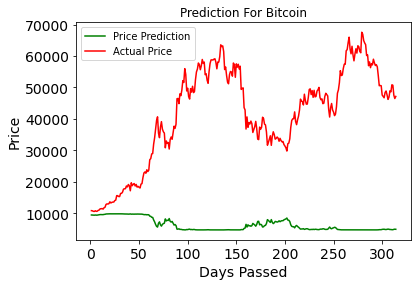

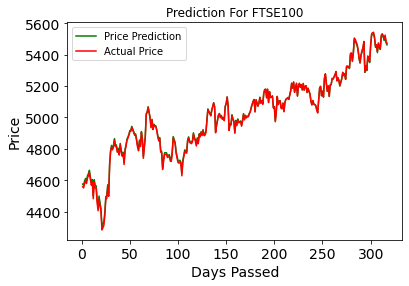

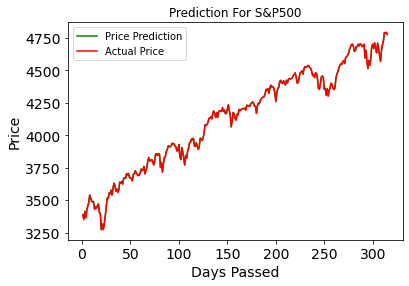

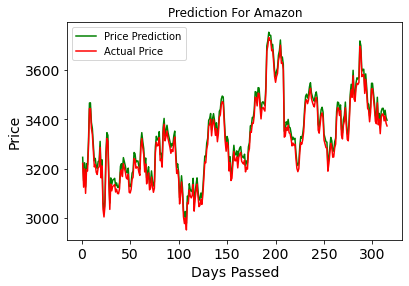

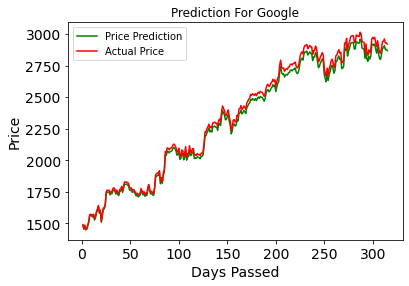

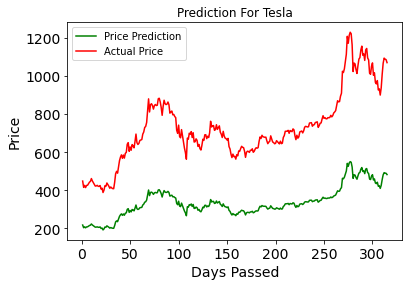

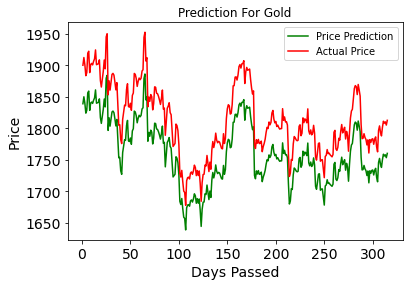

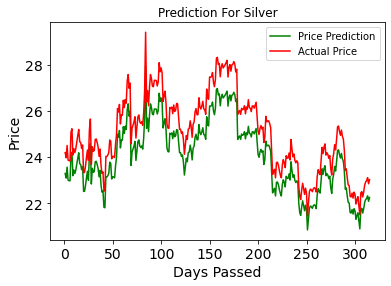

In [25]:
graphPredictions = True

# for each asset...
for i, data in enumerate(datasets):
  print('Analysis on {}'.format(datasetNames[i].upper()))
  # select the kernel with the highest confidence - saved from the above code cell
  kernel = assetConfidences[i][-1]
  
  # transform the data
  scaler = StandardScaler()
  scaler.fit(data)
  transformedData = scaler.transform(data)
  
  # make the prediction (and draw any graphs if desired)
  prediction, x_test, confidence = predictAsset(transformedData, kernel, c, test=True, toGraph=graphPredictions, graphForAsset=datasetNames[i])

  # print useful statistics
  print('Price Prediction: ', prediction[-1][0])
  print('Actual Price: ', x_test[-1][0])
  print('Mean Square Error: ', mean_squared_error(x_test, prediction))
  print('Mean Absolute Error: {}\n'.format(mean_absolute_error(x_test, prediction)))